In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

- Loading Flowers Image Data

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 160s 1us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


3670


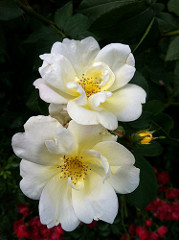

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))


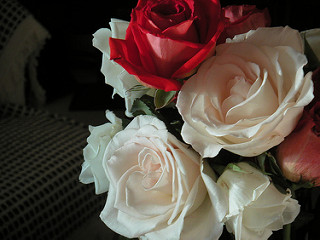

In [7]:
PIL.Image.open(str(roses[1]))


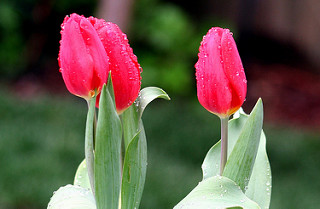

In [8]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))


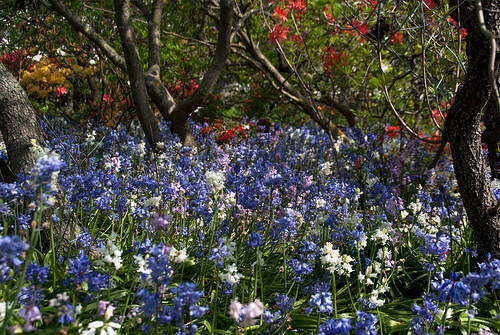

In [9]:
PIL.Image.open(str(tulips[1]))


- Getting the model pre-processed to default size with TF API

In [10]:
batch_size = 32
img_height = 180
img_width = 180


In [13]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


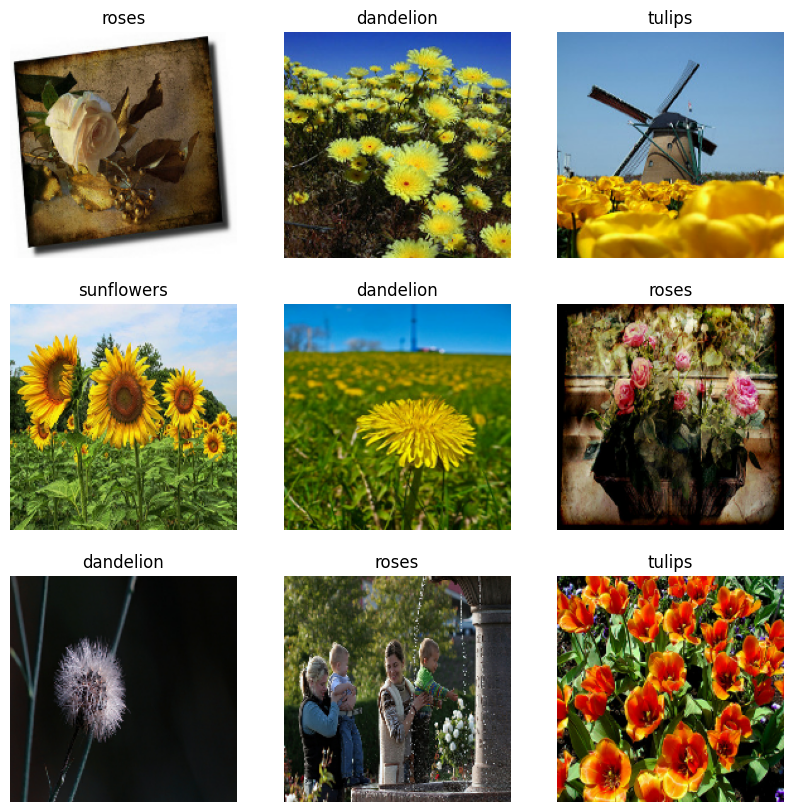

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [16]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 180, 180, 3)
(32,)


- Using TF API to cache the data, to remove I/O bottlenecks

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [20]:
normalization_layer = layers.Rescaling(1./255)


In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 0.99930793


- Creating a Convolutional Model with a normalization layer

In [22]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)


In [24]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

- Training the model

In [25]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
92/92 [==============================] - 14s 78ms/step - loss: 1.2877 - accuracy: 0.4452 - val_loss: 1.1312 - val_accuracy: 0.5204
Epoch 2/10
92/92 [==============================] - 5s 51ms/step - loss: 1.0036 - accuracy: 0.5974 - val_loss: 0.9455 - val_accuracy: 0.6240
Epoch 3/10
92/92 [==============================] - 5s 50ms/step - loss: 0.7843 - accuracy: 0.7020 - val_loss: 1.0240 - val_accuracy: 0.5913
Epoch 4/10
92/92 [==============================] - 5s 50ms/step - loss: 0.5845 - accuracy: 0.7878 - val_loss: 0.8622 - val_accuracy: 0.6703
Epoch 5/10
92/92 [==============================] - 5s 52ms/step - loss: 0.3666 - accuracy: 0.8702 - val_loss: 0.9326 - val_accuracy: 0.6826
Epoch 6/10
92/92 [==============================] - 5s 53ms/step - loss: 0.2149 - accuracy: 0.9278 - val_loss: 1.0313 - val_accuracy: 0.6839
Epoch 7/10
92/92 [==============================] - 5s 54ms/step - loss: 0.1036 - accuracy: 0.9697 - val_loss: 1.3414 - val_accuracy: 0.6485
Epoch 8/10
9

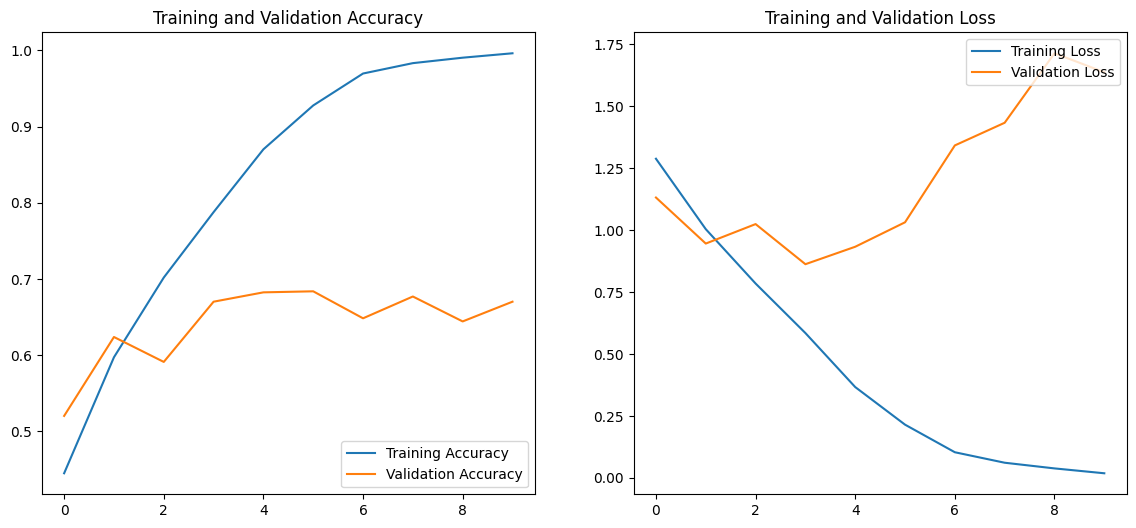

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


- **Data Augmentation** to reduce overfitting

In [28]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

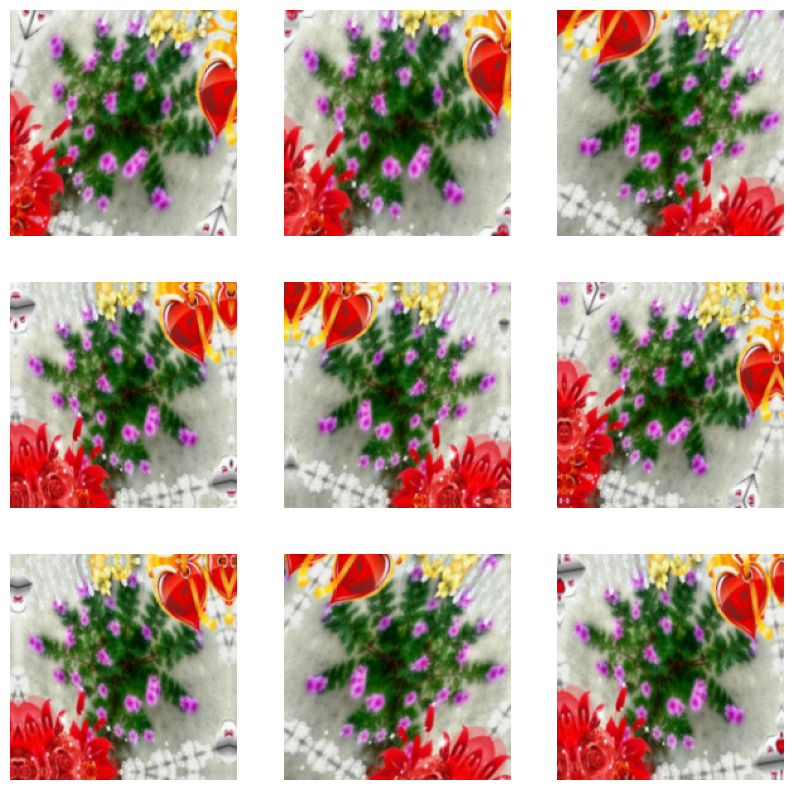

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


- We can see that through a simple sample we obtained 9, which mean that we will obtain 9x more data to train the model

- Using **Dropout**

In [30]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [32]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [33]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15
92/92 [==============================] - 63s 635ms/step - loss: 1.3761 - accuracy: 0.4128 - val_loss: 1.1538 - val_accuracy: 0.5450
Epoch 2/15
92/92 [==============================] - 57s 621ms/step - loss: 1.0645 - accuracy: 0.5691 - val_loss: 0.9862 - val_accuracy: 0.6049
Epoch 3/15
92/92 [==============================] - 57s 612ms/step - loss: 0.9626 - accuracy: 0.6161 - val_loss: 1.0263 - val_accuracy: 0.5845
Epoch 4/15
92/92 [==============================] - 55s 603ms/step - loss: 0.8974 - accuracy: 0.6461 - val_loss: 0.8944 - val_accuracy: 0.6512
Epoch 5/15
92/92 [==============================] - 56s 604ms/step - loss: 0.8388 - accuracy: 0.6649 - val_loss: 0.8958 - val_accuracy: 0.6567
Epoch 6/15
92/92 [==============================] - 56s 601ms/step - loss: 0.7694 - accuracy: 0.7003 - val_loss: 1.0593 - val_accuracy: 0.5967
Epoch 7/15
92/92 [==============================] - 56s 604ms/step - loss: 0.7636 - accuracy: 0.7061 - val_loss: 0.7884 - val_accuracy: 0.6935

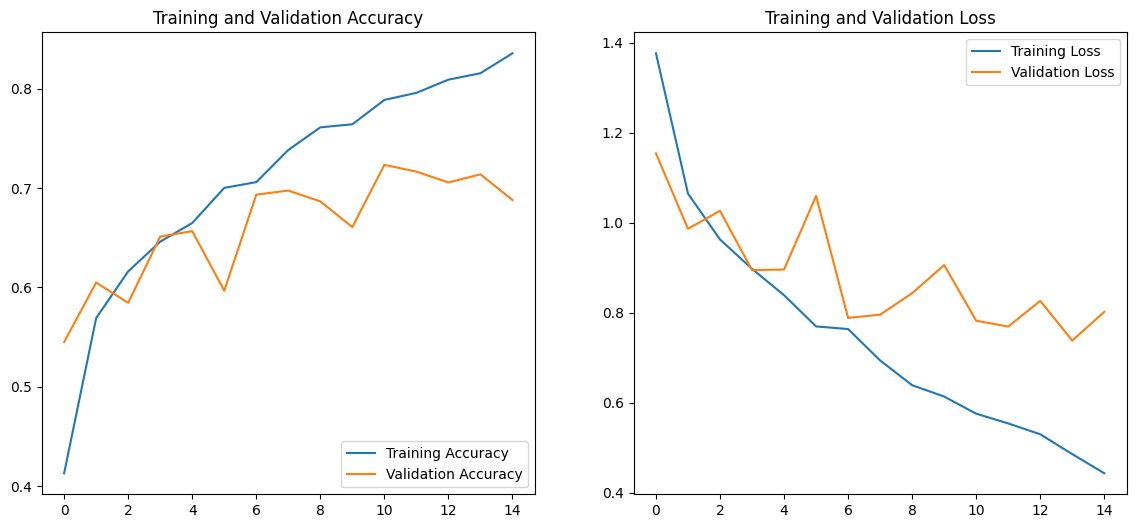

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
